In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)

iteration:,   0, ps_str, 301.312254
iteration:,   1, ps_str, 13044.853451
iteration:,   2, ps_str, 13046.425301
iteration:,   3, ps_str, 1282.149546
iteration:,   4, ps_str, 148.081582
iteration:,   5, ps_str, 148.081582
iteration:,   6, ps_str, 148.081582
iteration:,   7, ps_str, 148.081582
iteration:,   8, ps_str, 1282.149955
iteration:,   9, ps_str, 13046.106475
iteration:,  10, ps_str, 1282.187548
iteration:,  11, ps_str, 148.081582
iteration:,  12, ps_str, 148.081582
iteration:,  13, ps_str, 148.081582
iteration:,  14, ps_str, 148.081582
iteration:,  15, ps_str, 1281.808516
iteration:,  16, ps_str, 514.023756
iteration:,  17, ps_str, 13043.333486
iteration:,  18, ps_str, 13041.971654
iteration:,  19, ps_str, 1282.148075
iteration:,  20, ps_str, 520.221057
iteration:,  21, ps_str, 148.081582
iteration:,  22, ps_str, 13046.952185
iteration:,  23, ps_str, 1282.153737
iteration:,  24, ps_str, 148.081582
iteration:,  25, ps_str, 148.081582
iteration:,  26, ps_str, 148.081582
iteration:

In [2]:
#Nanosphere scattering spectrum

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_spectrum_nanosphere(radius, wvl_min, wvl_max):

    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    
    frq_min = 1 / wvl_max
    frq_max = 1 / wvl_min
    frq_cen = 0.5 * (frq_min + frq_max)
    dfrq = frq_max - frq_min
    nfrq = 100
    
    resolution = 85/r
    
    dpml = 2*r
    dair = 2*dpml
    
    pml_layers = [mp.PML(thickness=dpml)]
    
    #symmetries = [mp.Mirror(mp.Y)]
    
    s = 2 * (dpml + dair + r)
    cell_size = mp.Vector3(s, s)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
    mp.Source(
        mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
        center=mp.Vector3(-0.5 * s + dpml),
        size=mp.Vector3(0, s),
        component=mp.Ez)
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        default_material = default_material,
        sources=sources,
        k_point=mp.Vector3(),
    )

    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, 2 * r)),
    )
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, 2 * r)),
    )
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(2 * r, 0)),
    )
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(2 * r, 0)),
    )
    
    sim.run(until_after_sources=10)
    
    freqs = mp.get_flux_freqs(box_x1)
    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    
    box_x1_flux0 = mp.get_fluxes(box_x1)
    
    sim.reset_meep()


    
    geometry = [
        mp.Sphere(material=Au,
                  center=mp.Vector3(),
                  radius=r)
    ]
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        default_material = default_material,
        k_point=mp.Vector3(),
        geometry=geometry,
    )
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, 2 * r)),
    )
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, 2 * r)),
    )
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(2 * r, 0)),
    )
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(2 * r, 0)),
    )
        
    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    
    sim.run(until_after_sources=100)
    
    #flux power through each flux region.
    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)
    
    #Just want to plot the power of the scattered flux against wavelength
    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
    )

    return scatt_flux, freqs


In [3]:
wvl_min = 400E-3
wvl_max = 800E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []

r_min =10E-3
r_max =130E-3
radii = np.linspace(r_max,r_min,20)

index = 1

for r in radii:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs = get_spectrum_nanosphere(r, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)
    freq_data.append(freqs)

    index+=1


##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000832081 s
Working in 2D dimensions.
Computational cell is 1.82 x 1.82 x 0 with resolution 653.846
time for set_epsilon = 1.07631 s
-----------
Meep progress: 0.35558823529411765/18.0 = 2.0% done in 4.0s, 198.8s to go
on time step 465 (time=0.355588), 0.00861761 s/step
Meep progress: 0.7180588235294117/18.0 = 4.0% done in 8.0s, 192.8s to go
on time step 939 (time=0.718059), 0.0084417 s/step
Meep progress: 1.079/18.0 = 6.0% done in 12.0s, 188.4s to go
on time step 1411 (time=1.079), 0.00848034 s/step
Meep progress: 1.443/18.0 = 8.0% done in 16.0s, 183.7s to go
on time step 1887 (time=1.443), 0.00840504 s/step
Meep progress: 1.7985882352941178/18.0 = 10.0% done in 20.0s, 180.3s to go
on time step 2352 (time=1.79859), 0.00860911 s/step
Meep progress: 2.1534117647058824/18.0 = 12.0% done in 24.0s, 176.8s to go
on time step 2816 (time=2.15341), 0.00862509 s/s

run 0 finished at t = 108.00041795665635 (250965 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00110817 s
Working in 2D dimensions.
Computational cell is 0.935789 x 0.935789 x 0 with resolution 1271.65
time for set_epsilon = 2.12586 s
-----------
Meep progress: 0.11481114551083593/18.0 = 0.6% done in 4.0s, 624.0s to go
on time step 292 (time=0.114811), 0.0137192 s/step
Meep progress: 0.23316099071207433/18.0 = 1.3% done in 8.0s, 610.4s to go
on time step 593 (time=0.233161), 0.0133003 s/step
Meep progress: 0.34286068111455115/18.0 = 1.9% done in 12.0s, 618.6s to go
on time step 872 (time=0.342861), 0.0143406 s/step
Meep progress: 0.45609907120743043/18.0 = 2.5% done in 16.0s, 615.9s to go
on time step 1161 (time=0.456492), 0.0139071 s/step
Meep progress: 0.5756284829721363/18.0 = 3.2% done in 20.0s, 606.1s to go
on time step 1465 (time=0.576022), 0.0131755 s/step
Meep progress: 0.69043962

run 0 finished at t = 18.000185758513936 (45780 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000997782 s
Working in 2D dimensions.
Computational cell is 0.935789 x 0.935789 x 0 with resolution 1271.65
     sphere, center = (0,0,0)
          radius 0.0668421
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.25947 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.07195356037151704/108.0 = 0.1% done in 4.0s, 6003.1s to go
on time step 183 (time=0.0719536), 0.0218706 s/step
Meep progress: 0.14705263157894738/108.0 = 0.1% done in 8.0s, 5869.1s to go
on time step 375 (time=0.147446), 0.0209363 s/step
Meep progress: 0.1930557275541796/108.0 = 0.2% done in 12.0s, 6710.6s to go
on time step 492 (time=0.193449), 0.03443 s/step
Meep progress: 0.24849535603715175/108.0 = 0.2% done in 16.0s, 6952.7s to go
on time step 63

run 0 finished at t = 108.00032817337463 (274678 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00104403 s
Working in 2D dimensions.
Computational cell is 0.847368 x 0.847368 x 0 with resolution 1404.35
time for set_epsilon = 2.15991 s
-----------
Meep progress: 0.10075851393188853/18.0 = 0.6% done in 4.0s, 711.9s to go
on time step 283 (time=0.100759), 0.0141604 s/step
Meep progress: 0.2129102167182662/18.0 = 1.2% done in 8.0s, 669.6s to go
on time step 598 (time=0.21291), 0.0127218 s/step
Meep progress: 0.32613003095975224/18.0 = 1.8% done in 12.0s, 651.4s to go
on time step 916 (time=0.32613), 0.0125927 s/step
Meep progress: 0.4389938080495355/18.0 = 2.4% done in 16.0s, 641.1s to go
on time step 1233 (time=0.438994), 0.0126315 s/step
Meep progress: 0.5461609907120742/18.0 = 3.0% done in 20.0s, 640.2s to go
on time step 1534 (time=0.546161), 0.0133103 s/step
Meep progress: 0.654040247678

run 0 finished at t = 18.000170278637768 (50557 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00104499 s
Working in 2D dimensions.
Computational cell is 0.847368 x 0.847368 x 0 with resolution 1404.35
     sphere, center = (0,0,0)
          radius 0.0605263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.38528 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.06551083591331268/108.0 = 0.1% done in 4.0s, 6601.0s to go
on time step 184 (time=0.0655108), 0.0217754 s/step
Meep progress: 0.1331578947368421/108.0 = 0.1% done in 8.0s, 6499.5s to go
on time step 374 (time=0.133158), 0.0211386 s/step
Meep progress: 0.20258513931888542/108.0 = 0.2% done in 12.0s, 6407.5s to go
on time step 569 (time=0.202585), 0.0206025 s/step
Meep progress: 0.27414860681114545/108.0 = 0.3% done in 16.1s, 6307.0s to go
on time step 7

run 0 finished at t = 108.00006501547982 (1125291 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00138879 s
Working in 2D dimensions.
Computational cell is 0.14 x 0.14 x 0 with resolution 8500
time for set_epsilon = 2.5938 s
-----------
Meep progress: 0.01711764705882353/18.0 = 0.1% done in 4.0s, 4207.5s to go
on time step 291 (time=0.0171176), 0.0137635 s/step
Meep progress: 0.03429411764705882/18.0 = 0.2% done in 8.0s, 4196.2s to go
on time step 583 (time=0.0342941), 0.0137122 s/step
Meep progress: 0.05211764705882353/18.0 = 0.3% done in 12.0s, 4136.6s to go
on time step 886 (time=0.0521176), 0.0132065 s/step
Meep progress: 0.07/18.0 = 0.4% done in 16.0s, 4104.3s to go
on time step 1190 (time=0.07), 0.0131917 s/step
Meep progress: 0.0878235294117647/18.0 = 0.5% done in 20.0s, 4085.7s to go
on time step 1493 (time=0.0878235), 0.0132274 s/step
Meep progress: 0.10552941176470589/18.0 = 0.6%

run 0 finished at t = 18.0 (306000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00660801 s
Working in 2D dimensions.
Computational cell is 0.14 x 0.14 x 0 with resolution 8500
     sphere, center = (0,0,0)
          radius 0.01
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.5607 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.009588235294117647/108.0 = 0.0% done in 4.0s, 45260.1s to go
on time step 163 (time=0.00958824), 0.0246548 s/step
Meep progress: 0.019647058823529413/108.0 = 0.0% done in 8.0s, 44108.5s to go
on time step 334 (time=0.0196471), 0.0234283 s/step
Meep progress: 0.028176470588235296/108.0 = 0.0% done in 12.0s, 46146.1s to go
on time step 479 (time=0.0281765), 0.0276955 s/step
Meep progress: 0.03852941176470588/108.0 = 0.0% done in 16.1s, 45009.7s to go
on time step 655 (time=0.0385294)

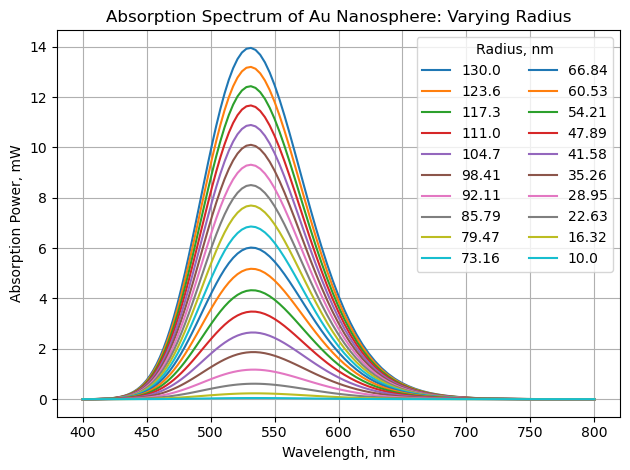

[1.30000000e-01 5.31543624e+02]
[1.23684211e-01 5.31543624e+02]
[1.17368421e-01 5.31543624e+02]
[1.11052632e-01 5.31543624e+02]
[1.04736842e-01 5.31543624e+02]
[9.84210526e-02 5.31543624e+02]
[9.21052632e-02 5.31543624e+02]
[8.57894737e-02 5.31543624e+02]
[7.94736842e-02 5.31543624e+02]
[7.31578947e-02 5.31543624e+02]
[6.68421053e-02 5.31543624e+02]
[6.05263158e-02 5.31543624e+02]
[5.42105263e-02 5.31543624e+02]
[4.78947368e-02 5.31543624e+02]
[4.15789474e-02 5.31543624e+02]
[3.52631579e-02 5.35135135e+02]
[2.89473684e-02 5.35135135e+02]
[2.26315789e-02 5.35135135e+02]
[1.63157895e-02 5.35135135e+02]
[1.00000000e-02 5.35135135e+02]
[1.3e-01 8.0e+02]
[1.23684211e-01 8.00000000e+02]
[1.17368421e-01 8.00000000e+02]
[1.11052632e-01 8.00000000e+02]
[1.04736842e-01 8.00000000e+02]
[9.84210526e-02 8.00000000e+02]
[9.21052632e-02 8.00000000e+02]
[8.57894737e-02 8.00000000e+02]
[7.94736842e-02 8.00000000e+02]
[7.31578947e-02 8.00000000e+02]
[6.68421053e-02 8.00000000e+02]
[6.05263158e-02 8.0000

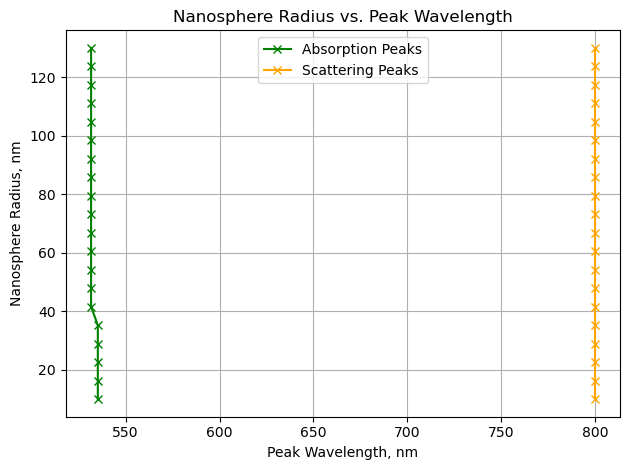

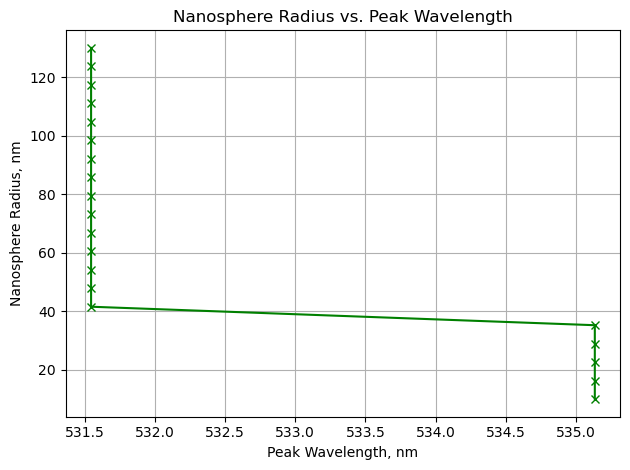

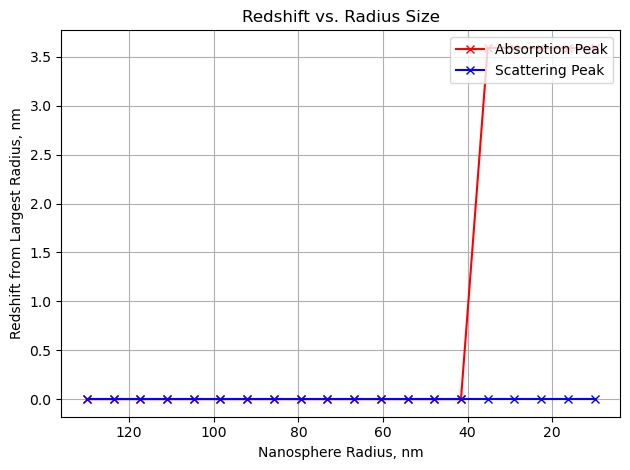

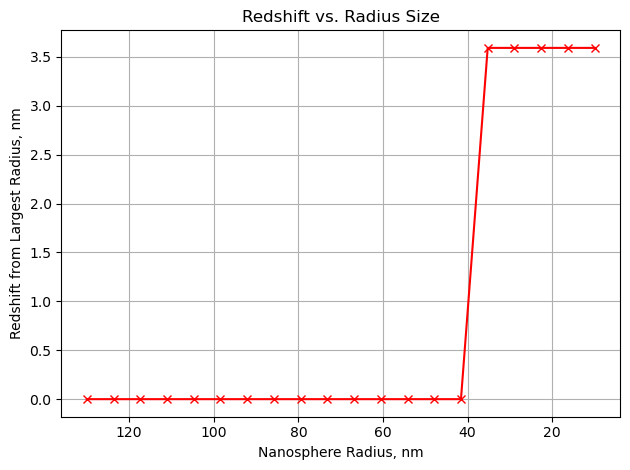

In [4]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.
#

for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    radius = radii[index]
    
    plt.plot(1E3/freqs, -1*scatt_flux*1E3, "-", label=f"{str(1E3*round(float(radius),5))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, mW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Radius, nm", ncol=2)
    plt.title("Absorption Spectrum of Au Nanosphere: Varying Radius")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append([radius, max_wvl_ab])
    max_wvls_sc.append([radius, max_wvl_sc])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="2 Absorption Spectrum of Au Nanosphere: Varying Radius",
            dpi=150, 
            bbox_inches="tight")
plt.show()
max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)

for row in max_wvls_ab:
    print(row)

for row in max_wvls_sc:
    print(row)

#plot curvature vs. peak position

plt.plot(max_wvls_ab[:,1], 1E3*max_wvls_ab[:,0], "gx-", label="Absorption Peaks")
plt.plot(max_wvls_sc[:,1], 1E3*max_wvls_sc[:,0], "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanosphere Radius, nm")
plt.title("Nanosphere Radius vs. Peak Wavelength")
plt.tight_layout()
plt.legend(loc="upper center")
plt.savefig(fname="Au Nanosphere Radius vs Peak Wavelength, both peaks",
            dpi=150, 
            bbox_inches="tight")
plt.show()

plt.plot(max_wvls_ab[:,1], 1E3*max_wvls_ab[:,0], "gx-", label="Absorption Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanosphere Radius, nm")
plt.title("Nanosphere Radius vs. Peak Wavelength")
plt.tight_layout()
plt.savefig(fname="Au Nanosphere Radius vs Peak Wavelength, one peaks",
            dpi=150, 
            bbox_inches="tight")
plt.show()

#Plot of redshift vs. AR

redshift_ab = max_wvls_ab[:,1]-max_wvls_ab[0,1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:,1]-max_wvls_sc[0,1]

plt.plot(1E3*radii, redshift_ab, "rx-", label="Absorption Peak")
plt.plot(1E3*radii, redshift_sc, "bx-", label="Scattering Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Nanosphere Radius, nm")
plt.ylabel("Redshift from Largest Radius, nm")
plt.title("Redshift vs. Radius Size")
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig(fname="2 Redshift vs Radius Size, both peaks",
            dpi=150, 
            bbox_inches="tight")
plt.show()


plt.plot(1E3*radii, redshift_ab, "rx-", label="Absorption Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Nanosphere Radius, nm")
plt.ylabel("Redshift from Largest Radius, nm")
plt.title("Redshift vs. Radius Size")
plt.tight_layout()
plt.savefig(fname="2 Redshift vs Radius Size, one peaks",
            dpi=150, 
            bbox_inches="tight")
plt.show()

